In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import seaborn as sns

In [81]:
n = 1000  # number of source samples
m = 1500  #number of target samples

# Source distribution: draw n samples from a standard Gaussian (mean=0, std=1)
X = np.random.normal(loc=0, scale=1, size=n)
a = np.ones(n)/n    # uniform weights over the source samples
print(f"Source distribution (n={n}): mean={X.mean():.2f}, std={X.std():.2f}, min={X.min():.2f}, max={X.max():.2f}")

# Target distribution: draw m samples from a bimodal Gaussian (two peaks at -10 and +10)
Y_1 = np.random.normal(loc=-10, scale=1, size=int(m/2))
Y_2 = np.random.normal(loc=10, scale=1, size=int(m/2))
Y = np.concatenate((Y_1, Y_2))
b = np.ones(m)/m    # uniform weights over the target samples
print(f"Target distribution (m={m}): mean={Y.mean():.2f}, std={Y.std():.2f}, min={Y.min():.2f}, max={Y.max():.2f}")

Source distribution (n=1000): mean=0.00, std=0.99, min=-3.30, max=3.01
Target distribution (m=1500): mean=-0.02, std=10.00, min=-13.64, max=12.95


In [82]:
# Compute the cost matrix 
def compute_cost_matrix(X, Y, p):
  cost_matrix = (np.abs(X[:, None] - Y[None, :])) ** p
  return cost_matrix

cost_matrix = compute_cost_matrix(X, Y, p=2)

#min-max normalization
cost_matrix_r = np.max(cost_matrix) - np.min(cost_matrix)
cost_matrix_min = np.min(cost_matrix)
cost_matrix = (cost_matrix - cost_matrix_min) / cost_matrix_r

# Print the cost matrix shape and min-max values
print(f"Cost matrix shape: {cost_matrix.shape}")
print(f"Cost matrix min: {np.min(cost_matrix)}")
print(f"Cost matrix max: {np.max(cost_matrix)}")

Cost matrix shape: (1000, 1500)
Cost matrix min: 0.0
Cost matrix max: 1.0


In [83]:
# Search for the smallest epsilon (regularization value) such that the kernel matrix has no zero entries
epsilon_values = np.logspace(-5, -2, num = 300)
for i in range(len(epsilon_values)):
  kernel_matrix = np.exp(-cost_matrix / epsilon_values[i])
  if not np.any(kernel_matrix == 0):
    epsilon = epsilon_values[i]
    break
  
print(f"Epsilon: {epsilon}")

# Print the kernel matrix shape and min-max values
print(f"Kernel matrix shape: {kernel_matrix.shape}")
print(f"Kernel matrix min: {np.min(kernel_matrix)}")
print(f"Kernel matrix max: {np.max(kernel_matrix)}")

Epsilon: 0.001371272434398401
Kernel matrix shape: (1000, 1500)
Kernel matrix min: 1.9538127e-317
Kernel matrix max: 1.0


In [84]:
def compute_transport_map_1D(x, beta, Y, b, epsilon):
    """
    Transport a single source point x to T(x).

    Uses the dual potentials (beta) and soft assignment P 
    to compute a barycentric projection onto Y.
    """
    # squared distances from x to every target point
    distances = (x - Y) ** 2    
    # rescale using same min–max like the global cost matrix 
    distances = (distances - cost_matrix_min) / cost_matrix_r

    # compute soft assignment P(x): normalized weights over targets Y
    numerators = b * np.exp((beta - distances) / epsilon)
    P = numerators / np.sum(numerators) 

    # weighted average of target points(barycentric transport)
    T_x = np.sum(P * Y)               
    return T_x

In [85]:
def wasserstein_distance_1D_quantile(ps, ts, n, p=1):
    """
    Approximate the 1D Wasserstein distance between two sample sets
    using the quantile method.

    The 1D Wasserstein distance (also called Earth Mover's Distance) 
    measures how much "work" is needed to transform one distribution 
    into another — in 1D, it equals the average distance between 
    their quantile functions.

    Args:
        ps (ndarray): source samples
        ts (ndarray): target samples
        n (int): number of quantile points to evaluate

    Returns:
        float: estimated Wasserstein distance
    """
    qs = np.linspace(0, 1, n)       # quantile grid

    ps_sorted = np.sort(ps)
    ts_sorted = np.sort(ts)

    q_ps = np.quantile(ps_sorted, qs)       # quantiles of source
    q_ts = np.quantile(ts_sorted, qs)       # quantiles of target

    return np.mean(np.abs(q_ps - q_ts) ** p) ** (1 / p)

In [86]:
def log_sinkhorn(cost_matrix, a, b, epsilon, max_iters=100000, tol=1e-9):
    """
    Run Sinkhorn iterations in log-space to compute dual potentials. During training, it also tracks the Wasserstein
    distance between transported source samples and the target distribution.

    Parameters:
    C : (n, m) cost matrix
    a : (n,) source weights 
    b : (m,) target weights 
    K : (n, m) kernel 
    eps : float, entropic regularization value
    max_iters : int, maximum iterations
    tol : float, stoppinfg tolerance for convergence

    Returns:
    alpha : (n,) dual potential for source
    beta  : (m,) dual potential for target
    wasserstein_history (list): history of Wasserstein distances across iterations
    """
    n, m = cost_matrix.shape
    alpha = np.zeros(n)         # dual potential for source
    beta = np.zeros(m)          # dual potential for target
    wasserstein_history = []    # track Wasserstein distance across iterations

    for i in range(max_iters):
        alpha_prev = alpha.copy()
        beta_prev = beta.copy()
        # Log-space updates
        alpha = epsilon * np.log(a) - epsilon * np.log(kernel_matrix @ np.exp(beta / epsilon))
        beta = epsilon * np.log(b) - epsilon * np.log(kernel_matrix.T @ np.exp(alpha / epsilon))
        # compute current transport map and Wasserstein distance
        transported_samples = np.array([compute_transport_map_1D(x, beta, Y, b, epsilon) for x in X])
        wasserstein_distance = wasserstein_distance_1D_quantile(transported_samples, Y, n, p=1)
        wasserstein_history.append(round(wasserstein_distance, 4))

        # print diagnostic info every 100 iterations
        if i % 100 == 0:
            Δα = np.linalg.norm(alpha - alpha_prev)
            Δβ = np.linalg.norm(beta  - beta_prev)
            print(f"Iter {i:6d} | Δα = {Δα} | Δβ = {Δβ} | W = {wasserstein_distance}")

        # convergence check every iter 
        if np.linalg.norm(alpha - alpha_prev) < tol:
            print(f"Convergence achieved at iteration: {i}")
            break

    return alpha, beta, wasserstein_history
alpha, beta, wasserstein_history = log_sinkhorn(cost_matrix, a, b, epsilon)

Iter      0 | Δα = 2.676459674707948 | Δβ = 5.4609348288550015 | W = 3.429617984416244
Iter    100 | Δα = 5.733910321222592e-05 | Δβ = 6.96286107780191e-05 | W = 0.18586346212524277
Iter    200 | Δα = 1.033441749647727e-05 | Δβ = 1.2548839716522833e-05 | W = 0.18598301944350568
Iter    300 | Δα = 1.8543950419970945e-06 | Δβ = 2.2517288014371564e-06 | W = 0.1860670485447452
Iter    400 | Δα = 3.324724790114824e-07 | Δβ = 4.0370938671327967e-07 | W = 0.1860836382527226
Iter    500 | Δα = 5.959962666326856e-08 | Δβ = 7.236966510483145e-08 | W = 0.18608736850032023
Iter    600 | Δα = 1.0683648650027196e-08 | Δβ = 1.2972766454056559e-08 | W = 0.18608803868377788
Iter    700 | Δα = 1.915109227247917e-09 | Δβ = 2.3254475524193793e-09 | W = 0.1860881588667908
Convergence achieved at iteration: 738


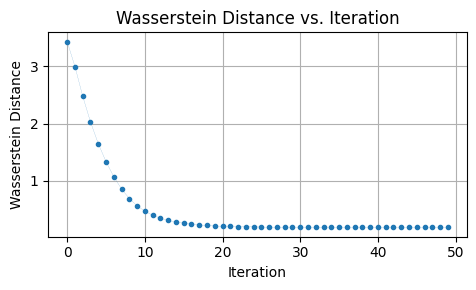

In [87]:
# Plotting how the Wasserstein distance evolves over the first 50 iterations
plt.figure(figsize=(5, 3))
plt.plot(wasserstein_history[0:50], marker='.', linestyle='-', linewidth=0.1)
plt.xlabel('Iteration')
plt.ylabel('Wasserstein Distance')
plt.title('Wasserstein Distance vs. Iteration')
plt.grid(True)
plt.tight_layout()
plt.show()

In [88]:
# Compute the transported version of each source sample 
transported_samples = np.array([compute_transport_map_1D(x, beta, Y, b, epsilon) for x in X])
print(transported_samples.max())
print(transported_samples.min())

12.557911389958235
-13.174638084346206


In [89]:
# CDF of X: given a value, return its percentile in X
X_sorted = np.sort(X)
F_X_vals = np.linspace(0, 1, n)
F_X_interp = interp1d(X_sorted, F_X_vals, bounds_error=False, fill_value=(0.0, 1.0))

# inverse CDF of Y: given a percentile, return the corresponding value in Y
Y_sorted = np.sort(Y)
F_Y_inv_interp = interp1d(np.linspace(0, 1, m), Y_sorted, bounds_error=False, fill_value="extrapolate")

"""
Transport map: take x, find its % in X, then send it to the same % in Y(which gives us the groundtruth)
Only possible in 1D
"""
def T(x):
    return F_Y_inv_interp(F_X_interp(x))

# map all of X into the "shape" of Y
X_mapped = T(X)

print(X_mapped.max())
print(X_mapped.min())

12.94702376753643
-13.637176478986115


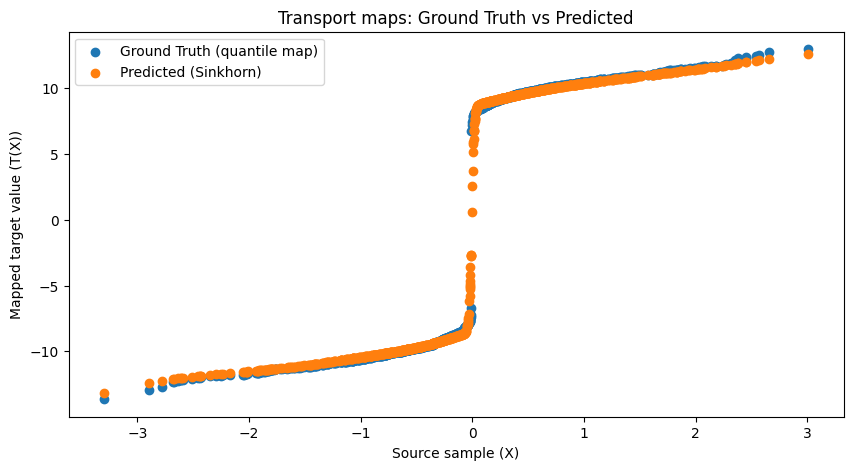

In [90]:
# Compare true transport map (quantile-based) vs. predicted transport from Sinkhorn
plt.figure(figsize=(10,5))
plt.scatter(X, X_mapped, label='Ground Truth (quantile map)')
plt.scatter(X, transported_samples, label='Predicted (Sinkhorn)')
plt.xlabel("Source sample (X)")
plt.ylabel("Mapped target value (T(X))")
plt.title("Transport maps: Ground Truth vs Predicted")
plt.legend()
plt.show()

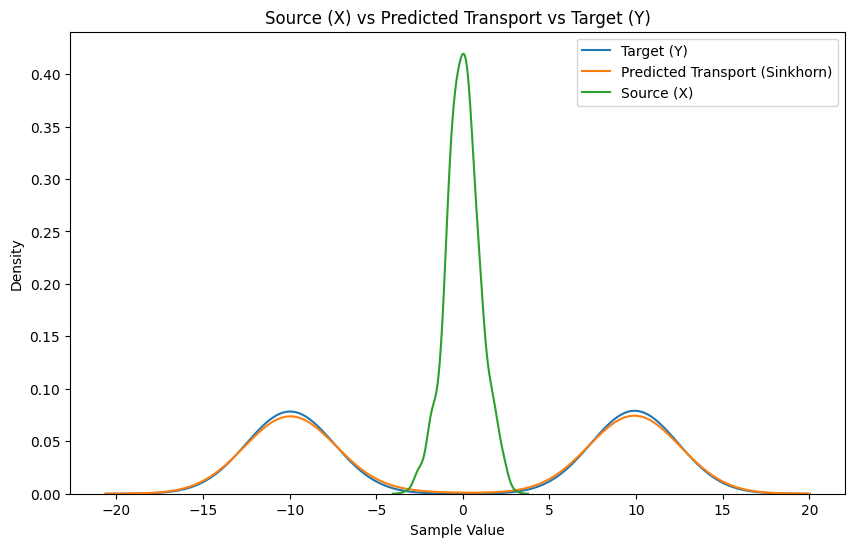

In [91]:
# Overlay KDE curves to compare source (X), predicted transport (Sinkhorn), and target (Y) distributions
plt.figure(figsize=(10, 6))

sns.kdeplot(Y, label="Target (Y)")
sns.kdeplot(transported_samples, label="Predicted Transport (Sinkhorn)")
sns.kdeplot(X, label="Source (X)")

plt.legend()
plt.title("Source (X) vs Predicted Transport vs Target (Y)")
plt.xlabel("Sample Value")
plt.ylabel("Density")
plt.show()